# 概要
混合モデルは、潜在変数でモデルをスイッチングする構造を持っている。そのため、潜在的に多クラスあるようなデータに対して有効なモデルである。

あらかじめクラスタ構造がわかっていて、データを明に分離できる場合には問題ないが、どのような特徴でデータが分割できるか自明ではない場合、なんらかの属性によって過度に分割してデータが少なくなってしまったり、複数の異なる特徴を合わせたデータになってしまったりする。

そこで、混合モデルを使ってこのようなデータ構造をモデリングしたい。

ここでは、複数の線形回帰モデルを組み合わせて複雑なデータ構造を推論してみる。

## コンテンツ
まずは、通常の線形回帰モデルをベイズ推論により求めてみる（「ベイズ線形回帰」と呼ばれてたりします）。

次に、トイデータを作って、線形回帰モデルを複数組み合わせたモデル（ここでは、混合線形回帰モデルと呼びます）を推論してみる。

## 参考
1. 須山, 「[ベイズ推論による機械学習 入門](https://www.amazon.co.jp/dp/4061538322/ref=cm_sw_r_tw_dp_U_x_193zEbE87QG1P)」, 2017, 講談社
2. C.M.ビショップ, 「パターン認識と機械学習 上下」, 2007, シュプリンガー・ジャパン
3. Osvaldo Martin, 「Pythonによるベイズ統計モデリング」, 2018, 共立出版
3. 弊ブログ, 「[ベイズ推論により混合分布のパラメータ推論をやってみる](https://learning-with-machine.hatenablog.com/entry/2020/03/09/083000)」

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
colors = np.array(sns.color_palette().as_hex())

In [3]:
from IPython.display import Image, display_png

# 線形回帰

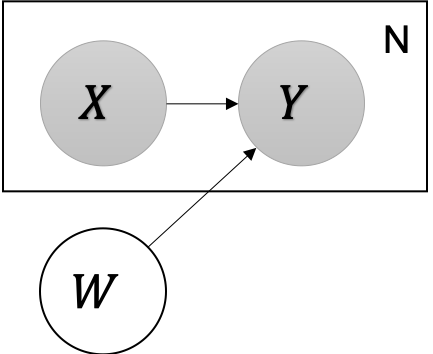

In [4]:
display_png(Image('img/linear_regression1.png'))

線形回帰モデルは、機械学習の分野で頻繁に登場するモデル。

データYがデータ$X$と確率変数$W$に依存する構造である。
$X$を説明変数、$Y$を目的変数、$W$を重みパラメータなど呼ぶ場合もある。
データ$(X,Y)$は予め与えられるものであり、未知の変数$W$を$(X,Y)$のペアに基づいて推論することが目的となる。

$W$を推論したあとで、未知の入力変数$x_*$に対する$p(y_* | x_*, W, X, Y)$を推論することができる。

最尤法などでパラメータを推論した場合には、予測値は分布ではなく一点で得られる。

線形回帰のベイズ推論については、解析解を求めることができ、詳しくは参考資料を参照。
弊ブログでもソースコード付きで記事を公開している

- [ベイズ線形回帰（解析解）の実装](https://learning-with-machine.hatenablog.com/entry/2019/10/31/183000)
- [サンプリングによる近似ベイズ推論 その3（MCMC:ギブスサンプリング）](https://learning-with-machine.hatenablog.com/entry/2019/12/05/193000)

ここでは、MCMCアルゴリズムを利用した近似解を取得する。MCMCアルゴリズムは、PyMC3を利用する。

## サンプルデータ
ここでは、2次の多項式に従うサンプルデータを使って、ベイズ線形回帰のパラメータ推論を試行する。

In [5]:
def polynomial(x, degree):
    """多項式
    """
    return [np.power(x, d) for d in np.arange(0, degree+1)]

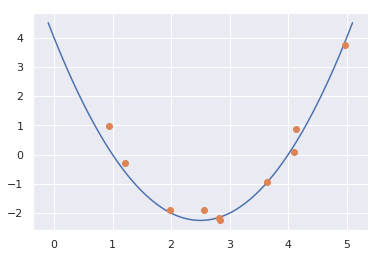

In [6]:
def true_func(x, params=None):
    y = np.dot(params['w'], polynomial(x, params['d']))
    return y
def observation_model(x, var=1.0, true_model_params=None):
    ty = true_func(x, params=true_model_params)
    y = np.random.normal(ty, np.sqrt(var))
    return y

n_sample = 10
xmin,xmax = 0, 5
sample_x = xmin + (xmax-xmin)*np.random.rand(n_sample) # 純粋にランダムにサンプル

tfunc_params = {'d':2, 'w':np.array([4.0, -5.0, 1.0])}
var_y = 0.1
sample_y = observation_model(sample_x, var=var_y, true_model_params=tfunc_params)

# plot
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)
xs = np.linspace(xmin-0.1, xmax+0.1, 1000)
tys = list(map(lambda x:true_func(x, params=tfunc_params), xs))
ax.plot(xs, tys, '-')
ax.plot(sample_x, sample_y, 'o')

## モデル構築
線形回帰モデルは先に掲載したグラフィカルモデルに基づく。

各変数の確率分布を定義する必要があり、ここでは、以下のように、観測モデルにガウスノイズを仮定したモデルを構築する。

$$
\begin{aligned}
& p(Y|X,W) = \mathcal{N}(y_n | f(W, X), \tau) \\
& f(W, X) = \sum^M_{m=0} w_m \phi_m(x) \\
& p(W) = \mathcal{N}(w | \mu, \Lambda) \\
& p(\tau) = \mathrm{Gamma}(\tau | \alpha, \beta)
\end{aligned}
$$

ここで$\phi_m(x)$は、$m=\{0, 1, \cdots, M\}$で、$x^m$を表す。

基底関数の解説など、線形回帰について詳しくは、弊ブログの以下の記事などを参照。

- [ベイズ線形回帰（解析解）の実装](https://learning-with-machine.hatenablog.com/entry/2019/10/31/183000)
- [サンプリングによる近似ベイズ推論 その3（MCMC:ギブスサンプリング）](https://learning-with-machine.hatenablog.com/entry/2020/03/06/225552)

このモデルは、観測モデルが平均$f(W, X)$のガウス分布であり、ガウス分布のパラメータ推論とほぼ同様のモデルとなる。
ガウス分布のパラメータ推論については、弊ブログの以下の記事などを参照。

- [ベイズ推論により混合分布のパラメータ推論をやってみる　〜まずはガウス分布のパラメータ推論〜](https://learning-with-machine.hatenablog.com/entry/2020/03/06/225552)

以下の例では、M=3、つまり3次の多項式で上記のトイデータを回帰することを試みる。
正解はM=2だが、冗長なモデルを使って推論を試行する。

In [7]:
# 多項式の次数
nd = 3

# 事前に基底関数をかけて特徴抽出したデータを作る
sample_x_feature = np.array(polynomial(x=sample_x, degree=nd))
print(sample_x_feature.shape)

(4, 10)


In [8]:
with pm.Model() as model_lr:
    tau = pm.Gamma('tau', alpha=1.0, beta=0.1)
    
    ws = pm.Normal('w', mu=0, tau=0.1, shape=nd+1)
    
    y = pm.Deterministic('y', pm.math.dot(ws, sample_x_feature))
    
    y_obs = pm.Normal('y_obs', mu=y, tau=tau, observed=sample_y)

## パラメータ推論

In [9]:
with model_lr:
    tr_lr = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, tau]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:26<00:00, 222.84draws/s]
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6790353513189474, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/Users/tok41/.local/share/virtualenvs/stats-dcrY3M1A/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x132ca9c10>,
      dtype=object)

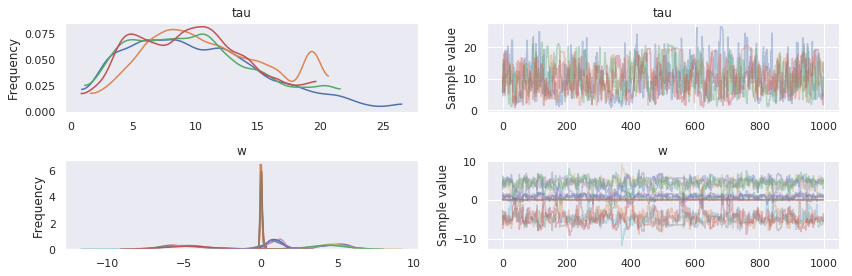

In [10]:
pm.traceplot(tr_lr, varnames=['tau', 'w'])

## 事後分布からの予測
推論結果として、パラメータWの事後分布が得られる。事後分布から数点をサンプリングして推論された関数を描画する。
また、関数の期待値（推論結果）を合わせて描画する。

In [11]:
tau_post = tr_lr['tau']
w_post = tr_lr['w']

x_test = np.linspace(-1, 6, 100)
x_test_feature = np.array(polynomial(x=x_test, degree=nd))
y_pred_dist = np.dot(w_post, x_test_feature)
y_pred = y_pred_dist.mean(axis=0) # モンテカルロ積分

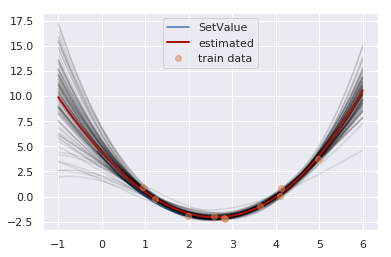

In [12]:
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)

ax.plot(xs, tys, '-', label='SetValue')

rand_idxs = np.random.randint(0, w_post.shape[0], 100)
for i in rand_idxs:
    y_test = np.dot(w_post[i], x_test_feature)
    ax.plot(x_test, y_test, '-', c='#000000', alpha=0.1)
ax.plot(x_test, y_pred, '-', c='#AA1010', lw=2, label='estimated')
ax.plot(sample_x, sample_y, 'o', alpha=0.5, label='train data')
ax.legend()

ベイズ推論された関数。グレーの薄い線は事後分布からサンプルした関数を描画したもの。赤線は関数の推論結果(期待値)を描画したもの。見えにくいが青い線で設定値を描画している。
図から、概ね設定値を推測できていることがわかる。しかし、学習に使ったデータから離れた領域ではグレーの線がバラついており、予測の不確かさを示している。

# 混合線形回帰
次に、上記の線形回帰モデルを複数組み合わせて複雑なデータ構造を推論してみる。

## 混合モデル


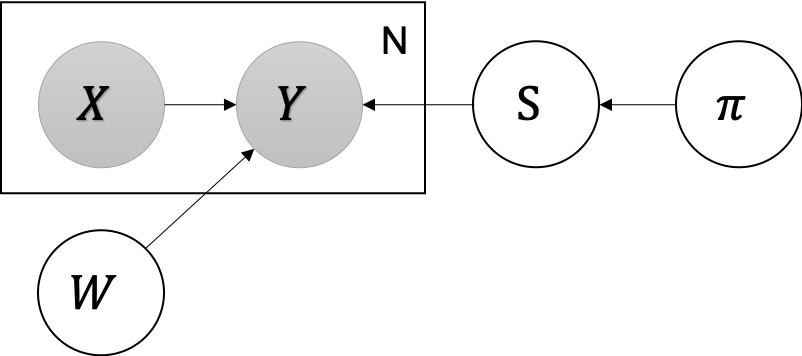

In [13]:
display_png(Image('img/mixture_linear_regression1.png'))

混合モデルについては、先に挙げた参考資料や、弊ブログの以下の記事を参照。
- [ベイズ推論により混合分布のパラメータ推論をやってみる　〜ガウス混合分布のパラメータ推論とクラスタリング〜](https://learning-with-machine.hatenablog.com/entry/2020/03/09/083000)

混合モデルとは、モデルが複数あり、それらのモデルを潜在変数$s$で切り替える構造のモデルである。
クラスタリングのように、複数のクラスがあるが各クラスのデータを事前に分離できない場合などに用いられる。

今回は線形モデルが複数組み合わさったモデルを考える。

線形モデルについては、上記の通りであり、観測される変数$y$が潜在変数$s$で切り替わる。
潜在変数$s$がどの程度選択されるかなどは$\pi$に依存する。

$$
\begin{aligned}
& p(Y|X,W,S) = \prod^K_{k=1} \mathcal{N}(y_n | f(W_k, x_n), \tau_k)^{s_k} \\
& f(W, X) = \sum^M_{m=0} w_m \phi_m(x) \\
& p(W) = \mathcal{N}(w | \mu, \Lambda) \\
& p(\tau) = \mathrm{Gamma}(\tau | \alpha, \beta) \\
& p(S|\pi) = \mathrm{Cat}(s | \pi) \\
& p(\pi) = \mathrm{Dir}(\pi | \alpha)
\end{aligned}
$$

上記の線形回帰モデルと、[前回のブログ](https://learning-with-machine.hatenablog.com/entry/2020/03/09/083000)で扱った混合モデルを組み合わせただけ。

## サンプルデータ
トイデータとして、先の例と同様に、二次関数に従うデータをサンプルする。
混合モデルなので、二つの異なる二次関数からデータをサンプルする。
なお、混ぜる関数は二次関数に限らず、また、同じ次数である必要もない。

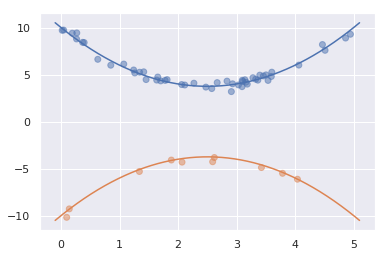

In [44]:
xmin,xmax = 0, 5
n_sample1 = 50
tfunc_params1 = {'d':2, 'w':np.array([10.0, -5.0, 1.0])}
var_y1 = 0.1
sample_x1 = xmin + (xmax-xmin)*np.random.rand(n_sample1)
sample_y1 = observation_model(sample_x1, var=var_y1, true_model_params=tfunc_params1)
cat_1 = np.ones(n_sample1) * 0
sample1 = np.stack([sample_x1, sample_y1, cat_1], axis=1)

n_sample2 = 10
tfunc_params2 = {'d':2, 'w':np.array([-10.0, 5.0, -1.0])}
#tfunc_params2 = {'d':2, 'w':np.array([-4.0, 5.0, -1.0])}
var_y2 = 0.1
sample_x2 = xmin + (xmax-xmin)*np.random.rand(n_sample2)
sample_y2 = observation_model(sample_x2, var=var_y2, true_model_params=tfunc_params2)
cat_2 = np.ones(n_sample2) * 1
sample2 = np.stack([sample_x2, sample_y2, cat_2], axis=1)

samples = np.concatenate([sample1, sample2], axis=0)
np.random.shuffle(samples) # 一応、データの順番をランダムにソートする

# plot
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)
xs = np.linspace(xmin-0.1, xmax+0.1, 1000)
tys = true_func(xs, params=tfunc_params1)
ax.plot(xs, tys, '-', color=colors[0])
tys = true_func(xs, params=tfunc_params2)
ax.plot(xs, tys, '-', color=colors[1])
ax.scatter(samples[:,0], samples[:,1], c=colors[samples[:,2].astype('int')], alpha=0.5)


得られたデータだけを観測するこのようになる。

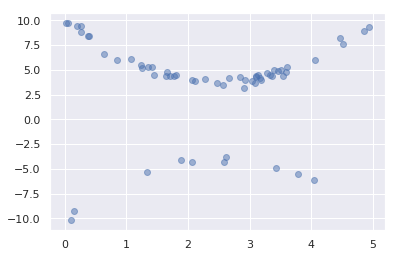

In [45]:
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)

ax.scatter(samples[:,0], samples[:,1], alpha=0.5)

## モデル構築
モデルは[前回のブログ](https://learning-with-machine.hatenablog.com/entry/2020/03/09/083000)で扱った混合モデルの例をそのまま拡張しただけである。
なお、混合モデルを扱った時の議論で、潜在変数$s$を周辺化除去することで、推論計算が非常に効率化することがわかっている。
ここでも、PyMC3のMixture APIを利用して、潜在変数を周辺化除去して計算を実行する。

In [46]:
# 多項式の次数
nd = 3

# 事前に基底関数をかけて特徴抽出したデータを作る
sample_x_feature = np.array(polynomial(x=samples[:,0], degree=nd))
print(sample_x_feature.shape)

(4, 60)


In [47]:
nk = 2
with pm.Model() as mlr:
    pi = pm.Dirichlet('pi', np.ones(nk))
    
    comp_dist = []
    for k in range(nk):
        tau = pm.Gamma('tau%i'%k, alpha=1.0, beta=0.1)        
        
        ws = pm.Normal('w%i'%k, mu=0, tau=0.1, shape=nd+1)
        y = pm.Deterministic('y%i'%k, pm.math.dot(ws, sample_x_feature))
        
        comp_dist.append(pm.Normal.dist(mu=y, tau=tau))
        
    y_obs = pm.Mixture('y_obs', pi, comp_dist, observed=samples[:,1])

## パラメータ推論

In [48]:
with mlr:
    tr_mlr = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w1, tau1, w0, tau0, pi]
100%|██████████| 1500/1500 [00:59<00:00, 25.14it/s]
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13383f7d0>,
      dtype=object)

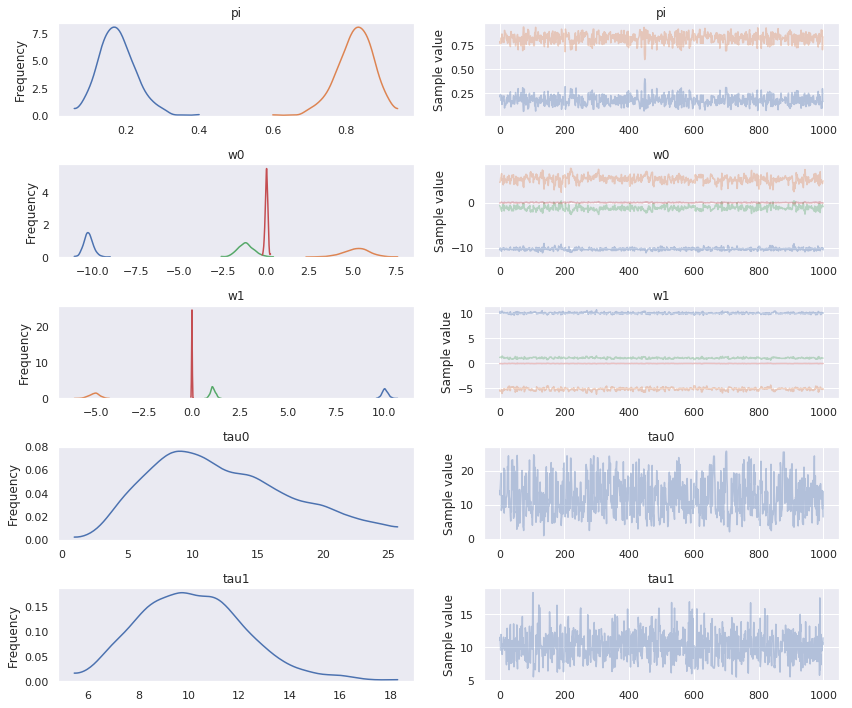

In [49]:
pm.traceplot(tr_mlr, varnames=['pi', 'w0', 'w1', 'tau0', 'tau1'])

## 事後分布からの予測
推論結果の可視化のため、得られた関数を描画する。
描画については、先の線形回帰の場合と同じである。

In [50]:
def pred_lr(x, w, degree):
    x_feature = np.array(polynomial(x=x, degree=degree))
    y_dist = np.dot(w, x_feature)
    y_pred = y_dist.mean(axis=0) # モンテカルロ積分
    return y_pred

In [51]:
def plot_sample_post(x, w, degree, ax, n_sample=100, c='#000000', alpha=0.1):
    rand_idxs = np.random.randint(0, w.shape[0], n_sample)
    x_feature = np.array(polynomial(x=x, degree=degree))
    for i in rand_idxs:
        y_pred = np.dot(w[i], x_feature)
        ax.plot(x, y_pred, '-', c=c, alpha=alpha)

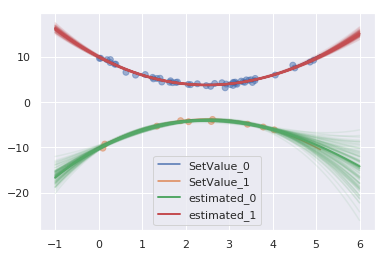

In [52]:
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)

xs = np.linspace(xmin-0.1, xmax+0.1, 1000)
tys = true_func(xs, params=tfunc_params1)
ax.plot(xs, tys, '-', color=colors[0], label='SetValue_0')
tys = true_func(xs, params=tfunc_params2)
ax.plot(xs, tys, '-', color=colors[1], label='SetValue_1')
ax.scatter(samples[:,0], samples[:,1], c=colors[samples[:,2].astype('int')], alpha=0.5)

# componet0
x_test = np.linspace(-1, 6, 100)
w_post = tr_mlr['w0']
y_pred = pred_lr(x_test, w_post, degree=nd)

plot_sample_post(x_test, w_post, nd, ax, c=colors[2])
ax.plot(x_test, y_pred, color=colors[2], lw=2, label='estimated_0')

# componet1
w_post = tr_mlr['w1']
y_pred = pred_lr(x_test, w_post, degree=nd)

plot_sample_post(x_test, w_post, nd, ax, c=colors[3])
ax.plot(x_test, y_pred, color=colors[3], lw=2, label='estimated_1')

ax.legend()

推論された関数。緑と赤の線が推論した線形モデルの各コンポーネントを示している。薄い線は事後分布からサンプルした関数を描画したもの。太い実線は関数の推論結果(期待値)を描画したもの。見えにくいが、設定値も合わせて描画している。
図から、概ね設定値を推測できていることがわかる。学習に使ったデータがない領域は推論結果がバラついていることがわかるまた、下の方のコンポーネントは学習に使うデータが少なかったため、推論のブレがより大きく不確かな度合いが大きいことがわかる。
